In [2]:
#load packages
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [3]:
#load data
path = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20221212_zooniverse_coco.json"
with open(path) as f:
  cocozoo = json.load(f)

len(cocozoo)

1396256

In [14]:
cocozoo[11010]

{'annotation_id': 11011,
 'bbox': [284.04296875, 55.65625, 62.30078125, 54.6328125],
 'area': 3403.6669006347656,
 'category_id': 3,
 'category': 'Duck',
 'image_id': 1582,
 'filename': 'BDA_18a4_20181106_2_00397_02_05.png',
 'labeler_id': 352}

In [23]:
dgc = []
for ann in cocozoo:
    if ann['category'] == 'Other Bird' or ann['category'] == 'Seagull':
        continue
    else:
        dgc.append(ann)
len(dgc)

1265589

In [ ]:
cocozoo.head()

In [7]:
testimg = "BDA_12c_20181113_1_00425_03_07.png"
snip = []
for img in dgc:
    if img["filename"] == testimg:
        snip.append(img)
    else:
        continue

len(snip)

155

In [35]:
with open("/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/scratch_tr_vl_ts/snip.json", "w") as outfile:
    json.dump(snip, outfile)

In [2]:
f = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/scratch_tr_vl_ts/snip.json"
with open(f, encoding='utf-8') as inputfile:
    df = pd.read_json(inputfile)

bboxes, filenames, cats = df["bbox"].to_list(), df["filename"].to_list(), df["category"].to_list()

In [1]:
df

NameError: name 'df' is not defined

In [3]:
xlist = []
ylist = []
wlist = []
hlist = []
for coords in bboxes:
     x = coords[0]
     xlist.append(x)
     y = coords[1]
     ylist.append(y)
     w = coords[2]
     wlist.append(w)
     h = coords[3]
     hlist.append(h)

In [9]:
df['bbox'][0][0]

530.1105346679688

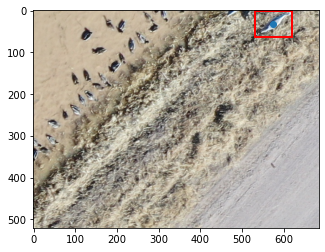

In [10]:
#Display bounding boxes on image for verification

#TEST: ONE BOX

fig, ax = plt.subplots()

img = cv2.imread(str('/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/subset/BDA_12c01_20181127_00425_03_07.png'))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)

x = df["bbox"][0][0]
y = df["bbox"][0][1]
w = df["bbox"][0][2]
h = df["bbox"][0][3]

x1 = x+(w/2)
y1 = y+(h/2)

ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))
ax.scatter(x1, y1)


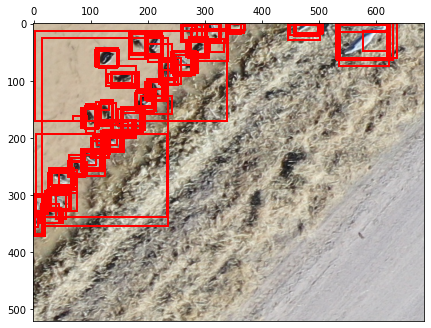

In [11]:
#DISPLAY ALL BOUNDING BOXES ON TEST IMAGE

def get_bb(bboxes, img):  
    boxes = bboxes.copy()
    
    return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img)  
  return ax

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  
def plot_sample(img,bboxes, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])

plot_sample(img,bboxes)

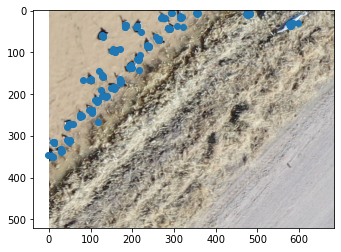

In [12]:
#Derive centers for all bboxes:
x = []
y = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    x.append(center[0])
    y.append(center[1])
    centers.append(center)

fig, ax = plt.subplots()
ax.imshow(img)
ax.scatter(x,y)

In [14]:
new = []
for row in centers:
    coord = list(row)
    new.append(coord)
new


[[574.5928344726562, 31.382583618164062],
 [482.3128967285156, 8.741943359375],
 [128.7530746459961, 62.08851623535156],
 [159.54574584960938, 98.19326782226562],
 [183.36691284179688, 38.34730529785156],
 [211.30892944335938, 37.80096435546875],
 [235.62554931640625, 84.91835021972656],
 [290.33544921875, 43.916351318359375],
 [272.0260009765625, 16.460281372070312],
 [46.60681915283203, 312.7657165527344],
 [49.31049346923828, 271.1090087890625],
 [100.57359313964844, 165.9356689453125],
 [74.81906127929688, 249.08108520507812],
 [103.62108612060547, 237.70901489257812],
 [115.08277893066406, 214.42755126953125],
 [137.3589859008789, 207.35589599609375],
 [127.5270004272461, 157.50286865234375],
 [155.1634979248047, 183.19427490234375],
 [174.1577606201172, 169.36965942382812],
 [194.77157592773438, 137.03025817871094],
 [211.46450805664062, 116.84976196289062],
 [263.28956604003906, 69.93675231933594],
 [313.81829833984375, 14.164306640625],
 [7.1827392578125, 350.9062194824219],
 [

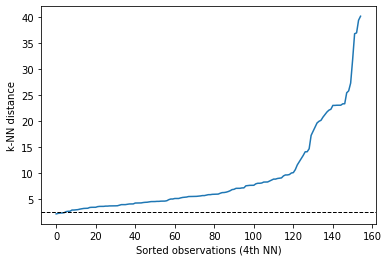

In [46]:
#Figure out inputs for DBSCAN

# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=10).fit(new)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(new)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

k_dist = sort_neigh_dist[:, 4]
plt.plot(k_dist)
plt.axhline(y=2.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [16]:
def plot_dbscan(db, X):
    # make a mask for each core point
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    plt.figure(figsize=[10, 10])
    unique_labels = set(db.labels_)
    for k in unique_labels:
        kdx = db.labels_ == k
        if k == -1:
            # these are the noise points
            color = 'k'
            plt.scatter(X[kdx, 0], X[kdx, 1], color=color, s=3)
        else:
            color = f'C{k}'
            core_kdx = kdx & core_samples_mask
            non_core_kdx = kdx & ~core_samples_mask
            plt.scatter(X[core_kdx, 0], X[core_kdx, 1], color=color, s=35, edgecolors=color)
            plt.scatter(X[non_core_kdx, 0], X[non_core_kdx, 1], color=color, s=5)

    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('X')
    plt.ylabel('Y')

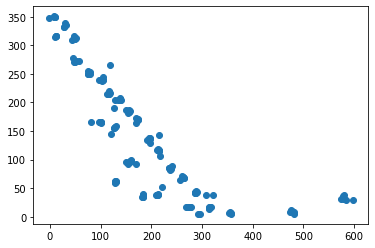

In [38]:
import numpy

array = numpy.array(new)
array

plt.scatter(array[:, 0], array[:, 1])
plt.show()

In [64]:
#define parameters for clustering
db = DBSCAN(eps=15, min_samples=5).fit(array)
#stores the cluster labels
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 23
Estimated number of noise points: 23


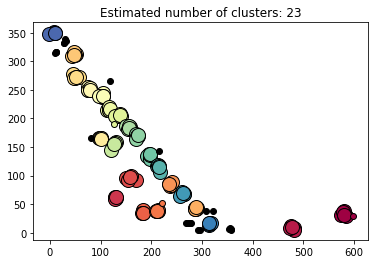

In [62]:
#Examine Clusters
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = array[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = array[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [ ]:
#Attach cluster ID to the implicated labels

In [ ]:
#Calculate median coordinates of xy and width/height
#  

In [ ]:
#Take plurality vote of classification label
